In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

# LSTM FORECASTING SETUP

Defining methods to set up data to return sequences of varying lengths (n_steps) for x and y:


We also plan to try to clean up the data more exhaustively.

In [3]:
LSTMData = pd.read_csv("/home/jik19004/FilesToRun/DINGRESEARCH/DingResearchDec28th/LSTMFolder/FINALIZED_DATA.csv")
display(LSTMData)

,Demand,Annual Usage (kWh),Year,Month,Day,Hour,WeekDay or Weekend,HVN_lon,HVN_lat,HVN_tmpf,...,DXR_drct,DXR_sknt,DXR_vsby,MMK_lon,MMK_lat,MMK_tmpf,MMK_drct,MMK_sknt,MMK_vsby,HotTemperatures
0,3053.00,13244.454545,2011,1,1,0,0,-72.8868,41.2638,33.980000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
1,2892.00,13244.454545,2011,1,1,1,0,-72.8868,41.2638,37.940000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
2,2774.00,13244.454545,2011,1,1,2,0,-72.8868,41.2638,37.040000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,5.0,5.0,0
3,2710.00,13244.454545,2011,1,1,3,0,-72.8868,41.2638,33.980000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,4.0,6.0,0
4,2698.00,13244.454545,2011,1,1,4,0,-72.8868,41.2638,30.920000,...,0.000000,0.000000,4.000000,-72.83,41.51,28.94,100.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96422,3310.60,14064.500000,2021,12,31,19,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96423,3148.00,14064.500000,2021,12,31,20,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96424,2988.93,14064.500000,2021,12,31,21,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96425,2793.70,14064.500000,2021,12,31,22,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0


# Splitting the Data into Training, Validation, and Testing! 

In [4]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameter 
import tensorflow as tf 
from tensorflow import keras as keras 

from tensorflow.python.client import device_lib
def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
print(get_available_devices())

2024-01-07 08:28:08.309271: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 08:28:08.311013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 08:28:08.339347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 08:28:08.339930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 08:28:08.933575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

['/device:CPU:0']


2024-01-07 08:28:09.941309: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


FOR LSTM Use previous data strictly to predict time t. 
Example: t-5,t-4,t-3,t-2,t-1 to predict the t time. 
This makes sense logically because at time t, you will obtain the values on that day but we want to predict ahead of time! 

In [5]:
DemandData = LSTMData.loc[:,"Demand"].copy()
def return_sequences(data, outputData, input_n_steps, output_n_steps):
    X = []
    Y = []
    length = len(data)
    for i in range(0,length, 1):
        input_indx = i + input_n_steps
        output_indx = input_indx + output_n_steps 
        if (output_indx > len(data)): # we need to have equally split sequences. 
            break               # The remaining data that cannot fit into a fixed
                                # sequence will immediately be cut!
        else:
            Xsample = data.iloc[i:input_indx, :] # get the previous data
            Ysample = outputData[input_indx:output_indx]
            X.append(Xsample)
            Y.append(Ysample) 
    X = np.asarray(X).astype('float64')
    Y = np.asarray(Y).astype('float64')
    return (X, Y)


In [6]:
from sklearn.preprocessing import StandardScaler 
def scaleTheData(data):
    scaler = StandardScaler()
    # split the data first. 
    data2 = scaler.fit_transform(data)
    data = pd.DataFrame(data2, columns = data.columns)
    return data

def splitDataAndScale(data, output):    
    TrainingData = scaleTheData(data.iloc[:61363, :].copy()) # The index for Janruary 1st basically, don't necessarily hard code it. 
    # Janruary 1st 2018. 
    TrainingOutput = output[:61363].copy()

    RemainingData = data.iloc[61363:, :].copy()
    RemainingOutput = output[61363:].copy()

    ValidationData = scaleTheData(RemainingData.iloc[:int(0.5*len(RemainingData)), :].copy())
    ValidationOutput = RemainingOutput[:int(0.5*len(RemainingOutput))].copy()

    TestingData = scaleTheData(RemainingData.iloc[int(0.5 * len(RemainingData)):, :].copy())
    TestingOutput = RemainingOutput[int(0.5 * len(RemainingData)):].copy()


    TrainingSequences = return_sequences(TrainingData, TrainingOutput, 18, 12) 

    TransformedTrainingData = TrainingSequences[0]
    TransformedTrainingOutput = TrainingSequences[1]

    ValidationSequences = return_sequences(ValidationData, ValidationOutput, 18, 12)

    TransformedValidationData = ValidationSequences[0]
    TransformedValidationOutput = ValidationSequences[1]

    TestingSequences = return_sequences(TestingData, TestingOutput, 18, 12)

    TransformedTestingData = TestingSequences[0]
    TransformedTestingOutput = TestingSequences[1]



    return (TransformedTrainingData, TransformedTrainingOutput, TransformedValidationData, TransformedValidationOutput, 
    TransformedTestingData, TransformedTestingOutput)
    
    

In [7]:
data = splitDataAndScale(LSTMData, DemandData)

# LSTM Model Construction 

In [8]:
import torch
r = torch.Tensor(np.array([1,2,3]))
y = torch.add(r,torch.Tensor(np.array([0,1,2])))

print(y)
print(r)

tensor([1., 3., 5.])
tensor([1., 2., 3.])


In [9]:
import torch 
class LSTMModel(torch.nn.Module):
    def __init__(self, alpha, num_layers, lastNeurons, LSTMNeurons, params, output_num =12):
        super(LSTMModel, self).__init__()
        self.LSTM1 = torch.nn.LSTM(input_size = 56, hidden_size = LSTMNeurons, num_layers = 1, bias = True, batch_first = True)
        self.LSTM2 = torch.nn.LSTM(input_size = LSTMNeurons, hidden_size = LSTMNeurons, num_layers = 1, bias = True, batch_first = True)
        self.batchNorm0 = torch.nn.BatchNorm1d(num_features = 18)
        self.Dropout0 = torch.nn.Dropout(0.5)
        self.LinearSkip = torch.nn.Linear(in_features = LSTMNeurons, out_features = lastNeurons, bias = True)
    
        
        input_size = LSTMNeurons
        layers = [] 
        for i in range(num_layers):
            num_units = params[i]
            layers.append(torch.nn.Linear(input_size, num_units, bias = True))
            layers.append(torch.nn.LeakyReLU(negative_slope = alpha))
            layers.append(torch.nn.BatchNorm1d(num_features = 18))
            layers.append(torch.nn.Dropout(0.5))
            input_size = num_units
        self.intermediateLayers = torch.nn.Sequential(*layers)
        self.Linear1 = torch.nn.Linear(in_features = input_size, out_features = lastNeurons, bias = True)
        self.Activation1 = torch.nn.LeakyReLU(negative_slope = alpha)
        self.Dropout1 = torch.nn.Dropout(0.5)
        
        
        self.Linear2 = torch.nn.Linear(in_features = lastNeurons * 18, out_features = output_num, bias = True)

        
        
        
    def forward(self, val):
        
        x = self.LSTM1(val)
        x = self.LSTM2(x[0], (x[1][0],x[1][1])) #(x[1][0], x[1][1])
        y = self.LinearSkip(x[0])
        x = self.batchNorm0(x[0])  
        x = self.Dropout0(x)          
        
        x = self.intermediateLayers(x)
        x = self.Linear1(x)
        x = self.Activation1(x)
        x = self.Dropout1(x)
        x = x.view(-1, x.size(1) * x.size(2))
        y = y.view(-1, y.size(1) * y.size(2))        
        
        x = self.Linear2(torch.add(x,y))
        
        return x
        

In [10]:
import optuna 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsolutePercentageError

class TimeSeriesDataset(Dataset):
    def __init__(self, data, output):
        data = torch.tensor(data).float(); 
        output = torch.tensor(output).float() 
        self.data = data 
        self.output = output; 

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, idx):
        x = self.data[idx];  
        y = self.output[idx]; 
        
        return x, y; 

# use the past 72 hours in advance and then predict the 1st hour, 6th hour, 12 hours! 

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
    return running_loss / len(val_loader.dataset)

def Train_and_Evaluate(train_loader, val_loader, device, params1, params2, numEpochs, early_stop_epochs):
    #num_layers, dropout = 0.1, outfeatures1 = 16, outfeatures2 = 16, outfeatures3 = 16, outfeatures4 = 16, dim_feedforward = 2048, output_num = 1
    model = LSTMModel(alpha = params1[0], num_layers = params1[1], lastNeurons= params1[2], LSTMNeurons = params1[3], params = params2)
    model = model.to(device);
    LossFunction = torch.nn.L1Loss();
    best_val_loss = float('inf')
    early_stop_count = 0
   
    
    Optimizer = torch.optim.Adam(params = model.parameters(), weight_decay = 0.03)
    for epoch in range(0,numEpochs):
        model.train() 
        Training_Loss = 0; 
        total_samples = 0; 
        for input, output in train_loader:
            input = input.to(device); 
            output = torch.squeeze(output, 1); 
            output = output.to(device); 
            predictedVal = model(input)
            predictedVal = torch.squeeze(predictedVal, 1)
            Optimizer.zero_grad();
            batchLoss = LossFunction(predictedVal, output);
            batchLoss.backward(); 
            Optimizer.step();
            Training_Loss += batchLoss * output.size(0) #* output.size(0);
            total_samples += output.size(0)
        Training_Loss = Training_Loss.item()/total_samples


        Validation_Loss = 0; 
        print("passed ", epoch, "epoch", "Training Loss: ", Training_Loss," ", end = "")
        with torch.no_grad():
            model.eval()
            total_val_samples = 0; 
            Validation_Loss = 0; 
            for val_input, val_output in val_loader:
                val_input = val_input.to(device); 
                val_output = torch.squeeze(val_output,1);
                val_output = val_output.to(device);
                predictedVal = model(val_input)
                predictedVal = torch.squeeze(predictedVal, 1)
                Validation_Loss += LossFunction(val_output, predictedVal) * val_output.size(0)
                total_val_samples += val_output.size(0)
            Validation_Loss = Validation_Loss/total_val_samples
            print("Validation Loss: ", Validation_Loss)

            if Validation_Loss < best_val_loss:
                best_val_loss = Validation_Loss
                early_stop_count = 0;
                torch.save(model, "//home//jik19004//FilesToRun//DINGRESEARCH/DingResearchDec28th//LSTMFolder//LSTM12")
            else:
                early_stop_count +=1 
            if early_stop_count >= early_stop_epochs:
                return best_val_loss; 

    return best_val_loss; 

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    act_outputs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu().numpy())
            act_outputs.append(_.numpy())

    return (np.concatenate(predictions), np.concatenate(act_outputs))

In [11]:
TrainingData = TimeSeriesDataset(data[0],data[1]);
TrainingLoader = DataLoader(TrainingData, batch_size = 128);


ValidationData = TimeSeriesDataset(data[2],data[3]);
ValidationLoader = DataLoader(ValidationData, batch_size = 128);


TestingData = TimeSeriesDataset(data[4],data[5]);
TestingLoader = DataLoader(TestingData, batch_size = 256);

In [12]:
def objective(trial):
    #num_layers = params[0], outfeatures = params[1], dim_feedforward = params[2]
    params1 = [trial.suggest_float("alpha", low = 0.2, high = 0.26, log=True), 
              trial.suggest_int("num_layers", low = 1, high = 3, step = 1),
              trial.suggest_int("last_hidden_neurons", low = 74, high = 122, step = 16),
              trial.suggest_int("LSTM_neurons", low = 72, high = 88, step = 8)]
    
    params2 = [trial.suggest_int("num_hiddenZero", low = 90, high = 138, step = 16),
               trial.suggest_int("num_hiddenOne", low = 106, high = 180, step = 16),
               trial.suggest_int("num_hiddenTwo", low = 74, high = 138, step = 16),
               trial.suggest_int("num_hiddenThree", low = 58, high = 124, step = 16)]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 20); 

import joblib 
study_name = 'sqlite:///LSTMOutput1.db'
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), study_name = "NewLSTM12", load_if_exists= True, storage='sqlite:///LSTMOutput12.db')
joblib.dump(study, "LSTMOutput12.pkl")
study.optimize(objective, n_trials = 160)

[I 2024-01-07 08:28:19,171] A new study created in RDB with name: NewLSTM12
/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [106, 180] and step=16, but the range is not divisible by `step`. It will be replaced by [106, 170].
  warnings.warn(
/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [58, 124] and step=16, but the range is not divisible by `step`. It will be replaced by [58, 122].
  warnings.warn(


passed  0 epoch Training Loss:  942.9181856718949  Validation Loss:  tensor(482.1397, device='cuda:2')
passed  1 epoch Training Loss:  509.8873381811067  Validation Loss:  tensor(406.6375, device='cuda:2')
passed  2 epoch Training Loss:  403.30619232399647  Validation Loss:  tensor(319.0052, device='cuda:2')
passed  3 epoch Training Loss:  334.84517559591745  Validation Loss:  tensor(272.1578, device='cuda:2')
passed  4 epoch Training Loss:  267.5031630090977  Validation Loss:  tensor(232.9666, device='cuda:2')
passed  5 epoch Training Loss:  225.30785534939838  Validation Loss:  tensor(259.9647, device='cuda:2')
passed  6 epoch Training Loss:  197.43341376724166  Validation Loss:  tensor(249.5664, device='cuda:2')
passed  7 epoch Training Loss:  177.15211791176182  Validation Loss:  tensor(264.9887, device='cuda:2')
passed  8 epoch Training Loss:  164.288877294812  Validation Loss:  tensor(275.5998, device='cuda:2')
passed  9 epoch Training Loss:  152.6022760622167  Validation Loss:  

[I 2024-01-07 08:33:47,262] Trial 0 finished with value: 143.70054626464844 and parameters: {'alpha': 0.23521048128006022, 'num_layers': 2, 'last_hidden_neurons': 90, 'LSTM_neurons': 80, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 106, 'num_hiddenThree': 58}. Best is trial 0 with value: 143.70054626464844.


Validation Loss:  tensor(207.1050, device='cuda:2')
passed  0 epoch Training Loss:  965.4568754687449  Validation Loss:  tensor(475.1507, device='cuda:2')
passed  1 epoch Training Loss:  526.7214921576939  Validation Loss:  tensor(429.0945, device='cuda:2')
passed  2 epoch Training Loss:  438.48100564124303  Validation Loss:  tensor(347.9496, device='cuda:2')
passed  3 epoch Training Loss:  350.66005804284737  Validation Loss:  tensor(286.8016, device='cuda:2')
passed  4 epoch Training Loss:  298.10516190041415  Validation Loss:  tensor(274.6707, device='cuda:2')
passed  5 epoch Training Loss:  249.02437473505722  Validation Loss:  tensor(239.6036, device='cuda:2')
passed  6 epoch Training Loss:  213.8549254899403  Validation Loss:  tensor(258.1837, device='cuda:2')
passed  7 epoch Training Loss:  192.12021064988423  Validation Loss:  tensor(245.0749, device='cuda:2')
passed  8 epoch Training Loss:  175.66760687383834  Validation Loss:  tensor(231.1485, device='cuda:2')
passed  9 epoch

[I 2024-01-07 08:38:11,984] Trial 1 finished with value: 146.85928344726562 and parameters: {'alpha': 0.2339965996323438, 'num_layers': 3, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 106, 'num_hiddenOne': 106, 'num_hiddenTwo': 138, 'num_hiddenThree': 74}. Best is trial 0 with value: 143.70054626464844.


Validation Loss:  tensor(177.0600, device='cuda:2')
passed  0 epoch Training Loss:  948.9753154857012  Validation Loss:  tensor(478.7135, device='cuda:2')
passed  1 epoch Training Loss:  519.9544787556657  Validation Loss:  tensor(389.3386, device='cuda:2')
passed  2 epoch Training Loss:  441.4392017478071  Validation Loss:  tensor(357.5218, device='cuda:2')
passed  3 epoch Training Loss:  372.13737894153326  Validation Loss:  tensor(292.3364, device='cuda:2')
passed  4 epoch Training Loss:  298.3043010402061  Validation Loss:  tensor(243.4715, device='cuda:2')
passed  5 epoch Training Loss:  237.48573385071901  Validation Loss:  tensor(233.1199, device='cuda:2')
passed  6 epoch Training Loss:  201.51441288681644  Validation Loss:  tensor(234.7055, device='cuda:2')
passed  7 epoch Training Loss:  178.18327518179152  Validation Loss:  tensor(244.9820, device='cuda:2')
passed  8 epoch Training Loss:  165.6689764241693  Validation Loss:  tensor(214.8227, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 08:43:15,807] Trial 2 finished with value: 145.75428771972656 and parameters: {'alpha': 0.24151240232519663, 'num_layers': 3, 'last_hidden_neurons': 90, 'LSTM_neurons': 88, 'num_hiddenZero': 106, 'num_hiddenOne': 170, 'num_hiddenTwo': 138, 'num_hiddenThree': 122}. Best is trial 0 with value: 143.70054626464844.


Validation Loss:  tensor(197.5466, device='cuda:2')
passed  0 epoch Training Loss:  980.6151889653373  Validation Loss:  tensor(485.8042, device='cuda:2')
passed  1 epoch Training Loss:  548.6840577819806  Validation Loss:  tensor(399.5369, device='cuda:2')
passed  2 epoch Training Loss:  432.6312974858969  Validation Loss:  tensor(344.7038, device='cuda:2')
passed  3 epoch Training Loss:  328.58320018260673  Validation Loss:  tensor(279.6713, device='cuda:2')
passed  4 epoch Training Loss:  282.75997000032606  Validation Loss:  tensor(261.0705, device='cuda:2')
passed  5 epoch Training Loss:  244.18899794567452  Validation Loss:  tensor(251.0216, device='cuda:2')
passed  6 epoch Training Loss:  213.16900903251053  Validation Loss:  tensor(298.5664, device='cuda:2')
passed  7 epoch Training Loss:  190.4676036130042  Validation Loss:  tensor(290.8728, device='cuda:2')
passed  8 epoch Training Loss:  175.8936968076434  Validation Loss:  tensor(254.2541, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 08:51:52,988] Trial 3 finished with value: 135.28549194335938 and parameters: {'alpha': 0.20727379395096474, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 80, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 138, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(138.0209, device='cuda:2')
passed  0 epoch Training Loss:  926.1677373072032  Validation Loss:  tensor(486.2362, device='cuda:2')
passed  1 epoch Training Loss:  515.3562461277595  Validation Loss:  tensor(383.4886, device='cuda:2')
passed  2 epoch Training Loss:  398.31069227508397  Validation Loss:  tensor(335.4217, device='cuda:2')
passed  3 epoch Training Loss:  314.5236899598917  Validation Loss:  tensor(276.2263, device='cuda:2')
passed  4 epoch Training Loss:  248.8556265692764  Validation Loss:  tensor(230.1562, device='cuda:2')
passed  5 epoch Training Loss:  209.70932924642125  Validation Loss:  tensor(219.7431, device='cuda:2')
passed  6 epoch Training Loss:  190.67339485440377  Validation Loss:  tensor(216.4806, device='cuda:2')
passed  7 epoch Training Loss:  174.3568330779013  Validation Loss:  tensor(224.2330, device='cuda:2')
passed  8 epoch Training Loss:  160.87525679068705  Validation Loss:  tensor(202.2692, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 08:58:11,108] Trial 4 finished with value: 143.67959594726562 and parameters: {'alpha': 0.2021296317662613, 'num_layers': 3, 'last_hidden_neurons': 122, 'LSTM_neurons': 80, 'num_hiddenZero': 138, 'num_hiddenOne': 138, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(213.9424, device='cuda:2')
passed  0 epoch Training Loss:  954.0078912185737  Validation Loss:  tensor(510.5678, device='cuda:2')
passed  1 epoch Training Loss:  540.6400365213422  Validation Loss:  tensor(442.4578, device='cuda:2')
passed  2 epoch Training Loss:  445.91662047151664  Validation Loss:  tensor(397.3717, device='cuda:2')
passed  3 epoch Training Loss:  372.05703198878274  Validation Loss:  tensor(305.5949, device='cuda:2')
passed  4 epoch Training Loss:  315.7303290181628  Validation Loss:  tensor(278.1911, device='cuda:2')
passed  5 epoch Training Loss:  266.0251899435876  Validation Loss:  tensor(269.0726, device='cuda:2')
passed  6 epoch Training Loss:  229.77770893794633  Validation Loss:  tensor(241.3187, device='cuda:2')
passed  7 epoch Training Loss:  212.27635569178597  Validation Loss:  tensor(224.3685, device='cuda:2')
passed  8 epoch Training Loss:  196.9726089933805  Validation Loss:  tensor(221.4038, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 09:05:47,160] Trial 5 finished with value: 147.52200317382812 and parameters: {'alpha': 0.20820617301953023, 'num_layers': 3, 'last_hidden_neurons': 90, 'LSTM_neurons': 80, 'num_hiddenZero': 90, 'num_hiddenOne': 106, 'num_hiddenTwo': 138, 'num_hiddenThree': 58}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(202.9910, device='cuda:2')
passed  0 epoch Training Loss:  963.2892685949066  Validation Loss:  tensor(476.9568, device='cuda:2')
passed  1 epoch Training Loss:  496.2929533374637  Validation Loss:  tensor(372.6520, device='cuda:2')
passed  2 epoch Training Loss:  404.1922913881371  Validation Loss:  tensor(342.0613, device='cuda:2')
passed  3 epoch Training Loss:  330.1033358333062  Validation Loss:  tensor(288.2526, device='cuda:2')
passed  4 epoch Training Loss:  281.03238008282517  Validation Loss:  tensor(262.1547, device='cuda:2')
passed  5 epoch Training Loss:  225.3598493494636  Validation Loss:  tensor(225.9271, device='cuda:2')
passed  6 epoch Training Loss:  205.8057684155607  Validation Loss:  tensor(227.8475, device='cuda:2')
passed  7 epoch Training Loss:  192.91365311246616  Validation Loss:  tensor(206.5900, device='cuda:2')
passed  8 epoch Training Loss:  185.95012554211368  Validation Loss:  tensor(201.6563, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 09:14:18,618] Trial 6 finished with value: 137.37425231933594 and parameters: {'alpha': 0.22611997945246828, 'num_layers': 3, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(147.7854, device='cuda:2')
passed  0 epoch Training Loss:  1004.1031727916001  Validation Loss:  tensor(496.3552, device='cuda:2')
passed  1 epoch Training Loss:  540.9442071281834  Validation Loss:  tensor(384.5743, device='cuda:2')
passed  2 epoch Training Loss:  421.8162193889197  Validation Loss:  tensor(317.9140, device='cuda:2')
passed  3 epoch Training Loss:  324.6052760296084  Validation Loss:  tensor(265.3635, device='cuda:2')
passed  4 epoch Training Loss:  265.0047771219878  Validation Loss:  tensor(242.6227, device='cuda:2')
passed  5 epoch Training Loss:  234.91774545928848  Validation Loss:  tensor(222.9682, device='cuda:2')
passed  6 epoch Training Loss:  208.86694166367758  Validation Loss:  tensor(243.7001, device='cuda:2')
passed  7 epoch Training Loss:  186.33836045260378  Validation Loss:  tensor(235.4285, device='cuda:2')
passed  8 epoch Training Loss:  172.56128737731112  Validation Loss:  tensor(227.6647, device='cuda:2')
passed  9 epoch 

[I 2024-01-07 09:17:57,588] Trial 7 finished with value: 150.1491241455078 and parameters: {'alpha': 0.21968681734777815, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 80, 'num_hiddenZero': 90, 'num_hiddenOne': 154, 'num_hiddenTwo': 90, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(158.8694, device='cuda:2')
passed  0 epoch Training Loss:  948.8896859816741  Validation Loss:  tensor(496.9136, device='cuda:2')
passed  1 epoch Training Loss:  512.2075194834839  Validation Loss:  tensor(423.7715, device='cuda:2')
passed  2 epoch Training Loss:  425.72455734176805  Validation Loss:  tensor(346.7814, device='cuda:2')
passed  3 epoch Training Loss:  343.24795382658886  Validation Loss:  tensor(313.2860, device='cuda:2')
passed  4 epoch Training Loss:  283.5823197573939  Validation Loss:  tensor(252.2110, device='cuda:2')
passed  5 epoch Training Loss:  231.75772002478234  Validation Loss:  tensor(224.4635, device='cuda:2')
passed  6 epoch Training Loss:  202.96036456125478  Validation Loss:  tensor(215.3734, device='cuda:2')
passed  7 epoch Training Loss:  184.88719144357125  Validation Loss:  tensor(216.2126, device='cuda:2')
passed  8 epoch Training Loss:  168.1127107314051  Validation Loss:  tensor(202.6786, device='cuda:2')
passed  9 epoch 

[I 2024-01-07 09:22:16,132] Trial 8 finished with value: 165.34555053710938 and parameters: {'alpha': 0.22414209658219808, 'num_layers': 3, 'last_hidden_neurons': 90, 'LSTM_neurons': 88, 'num_hiddenZero': 90, 'num_hiddenOne': 138, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(171.2442, device='cuda:2')
passed  0 epoch Training Loss:  995.0377930674666  Validation Loss:  tensor(527.3784, device='cuda:2')
passed  1 epoch Training Loss:  536.9957935239835  Validation Loss:  tensor(394.2871, device='cuda:2')
passed  2 epoch Training Loss:  397.1713242247367  Validation Loss:  tensor(316.6669, device='cuda:2')
passed  3 epoch Training Loss:  318.75025271464443  Validation Loss:  tensor(292.1515, device='cuda:2')
passed  4 epoch Training Loss:  276.44340822382367  Validation Loss:  tensor(246.1142, device='cuda:2')
passed  5 epoch Training Loss:  232.38808817295464  Validation Loss:  tensor(220.4036, device='cuda:2')
passed  6 epoch Training Loss:  206.54847229921413  Validation Loss:  tensor(208.8743, device='cuda:2')
passed  7 epoch Training Loss:  189.64789513157464  Validation Loss:  tensor(203.5718, device='cuda:2')
passed  8 epoch Training Loss:  174.35065379724134  Validation Loss:  tensor(201.8817, device='cuda:2')
passed  9 epoch

[I 2024-01-07 09:27:38,953] Trial 9 finished with value: 145.27322387695312 and parameters: {'alpha': 0.20091500852876296, 'num_layers': 3, 'last_hidden_neurons': 74, 'LSTM_neurons': 80, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 106, 'num_hiddenThree': 58}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(155.8218, device='cuda:2')
passed  0 epoch Training Loss:  922.1562591710959  Validation Loss:  tensor(464.4232, device='cuda:2')
passed  1 epoch Training Loss:  530.8329474679623  Validation Loss:  tensor(365.3431, device='cuda:2')
passed  2 epoch Training Loss:  414.47604917337856  Validation Loss:  tensor(329.1910, device='cuda:2')
passed  3 epoch Training Loss:  332.4336583298008  Validation Loss:  tensor(276.5954, device='cuda:2')
passed  4 epoch Training Loss:  266.8092248997294  Validation Loss:  tensor(266.1496, device='cuda:2')
passed  5 epoch Training Loss:  228.1808784687123  Validation Loss:  tensor(241.4120, device='cuda:2')
passed  6 epoch Training Loss:  201.73813871588354  Validation Loss:  tensor(223.2221, device='cuda:2')
passed  7 epoch Training Loss:  181.60830860534125  Validation Loss:  tensor(219.6967, device='cuda:2')
passed  8 epoch Training Loss:  162.4737991978348  Validation Loss:  tensor(256.2963, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 09:31:17,102] Trial 10 finished with value: 143.0590362548828 and parameters: {'alpha': 0.255482993098557, 'num_layers': 1, 'last_hidden_neurons': 122, 'LSTM_neurons': 88, 'num_hiddenZero': 138, 'num_hiddenOne': 170, 'num_hiddenTwo': 74, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(166.5158, device='cuda:2')
passed  0 epoch Training Loss:  925.2959859131965  Validation Loss:  tensor(496.0786, device='cuda:2')
passed  1 epoch Training Loss:  506.8547950565755  Validation Loss:  tensor(402.7032, device='cuda:2')
passed  2 epoch Training Loss:  412.8286431669221  Validation Loss:  tensor(301.4161, device='cuda:2')
passed  3 epoch Training Loss:  324.6609710764013  Validation Loss:  tensor(267.6862, device='cuda:2')
passed  4 epoch Training Loss:  262.83832784426255  Validation Loss:  tensor(238.5195, device='cuda:2')
passed  5 epoch Training Loss:  217.5366843838654  Validation Loss:  tensor(256.3102, device='cuda:2')
passed  6 epoch Training Loss:  193.35053966804708  Validation Loss:  tensor(292.7776, device='cuda:2')
passed  7 epoch Training Loss:  177.69028597515245  Validation Loss:  tensor(301.3128, device='cuda:2')
passed  8 epoch Training Loss:  166.9859131965957  Validation Loss:  tensor(297.8057, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 09:40:36,626] Trial 11 finished with value: 142.93585205078125 and parameters: {'alpha': 0.21451819613242026, 'num_layers': 2, 'last_hidden_neurons': 106, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 122, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(180.9410, device='cuda:2')
passed  0 epoch Training Loss:  978.389734894186  Validation Loss:  tensor(420.9032, device='cuda:2')
passed  1 epoch Training Loss:  492.78876316561775  Validation Loss:  tensor(336.7597, device='cuda:2')
passed  2 epoch Training Loss:  391.4478429582287  Validation Loss:  tensor(290.1606, device='cuda:2')
passed  3 epoch Training Loss:  320.7226660579776  Validation Loss:  tensor(250.1547, device='cuda:2')
passed  4 epoch Training Loss:  265.0716568298171  Validation Loss:  tensor(228.9823, device='cuda:2')
passed  5 epoch Training Loss:  234.59299898914142  Validation Loss:  tensor(249.9948, device='cuda:2')
passed  6 epoch Training Loss:  210.5462549320116  Validation Loss:  tensor(252.4715, device='cuda:2')
passed  7 epoch Training Loss:  192.04754296148954  Validation Loss:  tensor(249.4251, device='cuda:2')
passed  8 epoch Training Loss:  178.06824925816025  Validation Loss:  tensor(268.7520, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 09:45:37,351] Trial 12 finished with value: 152.31712341308594 and parameters: {'alpha': 0.21888815553374505, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 122, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(160.6765, device='cuda:2')
passed  0 epoch Training Loss:  921.8471320963903  Validation Loss:  tensor(445.6189, device='cuda:2')
passed  1 epoch Training Loss:  492.6008086868621  Validation Loss:  tensor(350.1264, device='cuda:2')
passed  2 epoch Training Loss:  389.83666481886064  Validation Loss:  tensor(277.0857, device='cuda:2')
passed  3 epoch Training Loss:  299.7752633123553  Validation Loss:  tensor(255.0648, device='cuda:2')
passed  4 epoch Training Loss:  239.55567874262238  Validation Loss:  tensor(290.0709, device='cuda:2')
passed  5 epoch Training Loss:  204.00053803763004  Validation Loss:  tensor(264.4682, device='cuda:2')
passed  6 epoch Training Loss:  186.28995337007206  Validation Loss:  tensor(253.6495, device='cuda:2')
passed  7 epoch Training Loss:  178.2587634917012  Validation Loss:  tensor(215.4733, device='cuda:2')
passed  8 epoch Training Loss:  170.8060618906316  Validation Loss:  tensor(209.9039, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 09:53:57,836] Trial 13 finished with value: 141.5265350341797 and parameters: {'alpha': 0.2108091986101188, 'num_layers': 2, 'last_hidden_neurons': 106, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 122, 'num_hiddenThree': 74}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(149.0982, device='cuda:2')
passed  0 epoch Training Loss:  979.9076531776828  Validation Loss:  tensor(464.6847, device='cuda:2')
passed  1 epoch Training Loss:  545.0528907294486  Validation Loss:  tensor(364.9621, device='cuda:2')
passed  2 epoch Training Loss:  414.4084846903838  Validation Loss:  tensor(314.3489, device='cuda:2')
passed  3 epoch Training Loss:  328.0567059053706  Validation Loss:  tensor(279.4364, device='cuda:2')
passed  4 epoch Training Loss:  272.21860631949653  Validation Loss:  tensor(248.2439, device='cuda:2')
passed  5 epoch Training Loss:  243.33457788502298  Validation Loss:  tensor(230.9919, device='cuda:2')
passed  6 epoch Training Loss:  220.61973782893665  Validation Loss:  tensor(233.4714, device='cuda:2')
passed  7 epoch Training Loss:  201.8761046075586  Validation Loss:  tensor(254.6943, device='cuda:2')
passed  8 epoch Training Loss:  184.43693546809274  Validation Loss:  tensor(259.3411, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 09:59:14,189] Trial 14 finished with value: 150.3155517578125 and parameters: {'alpha': 0.22611169797471747, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 138, 'num_hiddenOne': 170, 'num_hiddenTwo': 122, 'num_hiddenThree': 74}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(152.9442, device='cuda:2')
passed  0 epoch Training Loss:  966.440864773209  Validation Loss:  tensor(495.1237, device='cuda:2')
passed  1 epoch Training Loss:  528.3894088107738  Validation Loss:  tensor(416.9423, device='cuda:2')
passed  2 epoch Training Loss:  405.5312877033945  Validation Loss:  tensor(300.2497, device='cuda:2')
passed  3 epoch Training Loss:  303.17869370985096  Validation Loss:  tensor(269.1115, device='cuda:2')
passed  4 epoch Training Loss:  248.13040075651352  Validation Loss:  tensor(284.9889, device='cuda:2')
passed  5 epoch Training Loss:  214.41867479701307  Validation Loss:  tensor(252.1815, device='cuda:2')
passed  6 epoch Training Loss:  198.4275768741644  Validation Loss:  tensor(237.3983, device='cuda:2')
passed  7 epoch Training Loss:  186.60713470505755  Validation Loss:  tensor(213.6400, device='cuda:2')
passed  8 epoch Training Loss:  175.5810480320866  Validation Loss:  tensor(204.4818, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 10:04:59,141] Trial 15 finished with value: 141.43939208984375 and parameters: {'alpha': 0.20743191120042387, 'num_layers': 2, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 90, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(171.7383, device='cuda:2')
passed  0 epoch Training Loss:  931.6652427691004  Validation Loss:  tensor(489.3273, device='cuda:2')
passed  1 epoch Training Loss:  520.4551146183194  Validation Loss:  tensor(438.2657, device='cuda:2')
passed  2 epoch Training Loss:  440.45247334268106  Validation Loss:  tensor(360.6022, device='cuda:2')
passed  3 epoch Training Loss:  334.4587993608765  Validation Loss:  tensor(288.1389, device='cuda:2')
passed  4 epoch Training Loss:  274.3840610428148  Validation Loss:  tensor(267.7060, device='cuda:2')
passed  5 epoch Training Loss:  232.4618645449506  Validation Loss:  tensor(254.7048, device='cuda:2')
passed  6 epoch Training Loss:  206.0900968467734  Validation Loss:  tensor(232.4167, device='cuda:2')
passed  7 epoch Training Loss:  190.50438582189324  Validation Loss:  tensor(210.3946, device='cuda:2')
passed  8 epoch Training Loss:  177.98772295953304  Validation Loss:  tensor(217.0393, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 10:08:04,528] Trial 16 finished with value: 148.7751007080078 and parameters: {'alpha': 0.21571998780515364, 'num_layers': 2, 'last_hidden_neurons': 106, 'LSTM_neurons': 88, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 122, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(211.9445, device='cuda:2')
passed  0 epoch Training Loss:  956.9738807186878  Validation Loss:  tensor(470.7127, device='cuda:2')
passed  1 epoch Training Loss:  533.5784393647895  Validation Loss:  tensor(352.4456, device='cuda:2')
passed  2 epoch Training Loss:  396.649166856882  Validation Loss:  tensor(311.6422, device='cuda:2')
passed  3 epoch Training Loss:  311.1108031434441  Validation Loss:  tensor(284.9601, device='cuda:2')
passed  4 epoch Training Loss:  262.4068053608113  Validation Loss:  tensor(252.2864, device='cuda:2')
passed  5 epoch Training Loss:  234.01178791534875  Validation Loss:  tensor(226.2434, device='cuda:2')
passed  6 epoch Training Loss:  205.38720774774188  Validation Loss:  tensor(243.6460, device='cuda:2')
passed  7 epoch Training Loss:  184.77302964098217  Validation Loss:  tensor(237.6467, device='cuda:2')
passed  8 epoch Training Loss:  170.61478136107218  Validation Loss:  tensor(271.3745, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 10:11:53,831] Trial 17 finished with value: 157.31381225585938 and parameters: {'alpha': 0.222534122915325, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 80, 'num_hiddenZero': 138, 'num_hiddenOne': 122, 'num_hiddenTwo': 106, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(164.7825, device='cuda:2')
passed  0 epoch Training Loss:  953.9666090585972  Validation Loss:  tensor(495.8975, device='cuda:2')
passed  1 epoch Training Loss:  540.5875370919881  Validation Loss:  tensor(424.0281, device='cuda:2')
passed  2 epoch Training Loss:  411.598656536342  Validation Loss:  tensor(341.0656, device='cuda:2')
passed  3 epoch Training Loss:  328.24632340952815  Validation Loss:  tensor(288.0923, device='cuda:2')
passed  4 epoch Training Loss:  268.517624808426  Validation Loss:  tensor(244.2370, device='cuda:2')
passed  5 epoch Training Loss:  232.32923011706396  Validation Loss:  tensor(249.0377, device='cuda:2')
passed  6 epoch Training Loss:  206.67626438843055  Validation Loss:  tensor(223.7736, device='cuda:2')
passed  7 epoch Training Loss:  189.82427364919945  Validation Loss:  tensor(216.2825, device='cuda:2')
passed  8 epoch Training Loss:  175.87427854045066  Validation Loss:  tensor(198.2672, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 10:18:25,920] Trial 18 finished with value: 143.26724243164062 and parameters: {'alpha': 0.22941233727914248, 'num_layers': 2, 'last_hidden_neurons': 74, 'LSTM_neurons': 80, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 90, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(169.5027, device='cuda:2')
passed  0 epoch Training Loss:  973.5190921837806  Validation Loss:  tensor(453.2289, device='cuda:2')
passed  1 epoch Training Loss:  509.7671112270519  Validation Loss:  tensor(436.8773, device='cuda:2')
passed  2 epoch Training Loss:  404.0221410636841  Validation Loss:  tensor(327.0561, device='cuda:2')
passed  3 epoch Training Loss:  320.1663677568722  Validation Loss:  tensor(268.2642, device='cuda:2')
passed  4 epoch Training Loss:  266.69395441353896  Validation Loss:  tensor(248.5587, device='cuda:2')
passed  5 epoch Training Loss:  235.21552483125183  Validation Loss:  tensor(249.4331, device='cuda:2')
passed  6 epoch Training Loss:  209.48007630351844  Validation Loss:  tensor(269.0942, device='cuda:2')
passed  7 epoch Training Loss:  189.64213975935044  Validation Loss:  tensor(283.1281, device='cuda:2')
passed  8 epoch Training Loss:  176.1182215410702  Validation Loss:  tensor(281.2141, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 10:25:43,933] Trial 19 finished with value: 136.50668334960938 and parameters: {'alpha': 0.21356636682201974, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 72, 'num_hiddenZero': 106, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(164.0984, device='cuda:2')
passed  0 epoch Training Loss:  966.7728176867643  Validation Loss:  tensor(484.1843, device='cuda:2')
passed  1 epoch Training Loss:  540.4629406202107  Validation Loss:  tensor(374.5648, device='cuda:2')
passed  2 epoch Training Loss:  410.8958489581635  Validation Loss:  tensor(317.0182, device='cuda:2')
passed  3 epoch Training Loss:  315.54987445788635  Validation Loss:  tensor(255.2579, device='cuda:2')
passed  4 epoch Training Loss:  256.4066260149346  Validation Loss:  tensor(249.1516, device='cuda:2')
passed  5 epoch Training Loss:  222.36247432093128  Validation Loss:  tensor(288.2530, device='cuda:2')
passed  6 epoch Training Loss:  189.66765578635014  Validation Loss:  tensor(249.1419, device='cuda:2')
passed  7 epoch Training Loss:  171.12278670884012  Validation Loss:  tensor(244.4255, device='cuda:2')
passed  8 epoch Training Loss:  158.7616819382398  Validation Loss:  tensor(264.7569, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 10:36:22,908] Trial 20 finished with value: 138.3023681640625 and parameters: {'alpha': 0.2056955820133409, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 80, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 122, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(232.4728, device='cuda:2')
passed  0 epoch Training Loss:  979.1761176508951  Validation Loss:  tensor(457.6608, device='cuda:2')
passed  1 epoch Training Loss:  502.27942087586007  Validation Loss:  tensor(375.9407, device='cuda:2')
passed  2 epoch Training Loss:  401.18492190302277  Validation Loss:  tensor(318.4237, device='cuda:2')
passed  3 epoch Training Loss:  320.3274529624678  Validation Loss:  tensor(259.4851, device='cuda:2')
passed  4 epoch Training Loss:  262.3818273714416  Validation Loss:  tensor(246.7902, device='cuda:2')
passed  5 epoch Training Loss:  226.27395897870676  Validation Loss:  tensor(293.9051, device='cuda:2')
passed  6 epoch Training Loss:  197.79463266703624  Validation Loss:  tensor(315.9018, device='cuda:2')
passed  7 epoch Training Loss:  182.50658688492516  Validation Loss:  tensor(292.4412, device='cuda:2')
passed  8 epoch Training Loss:  170.47104379300225  Validation Loss:  tensor(233.4390, device='cuda:2')
passed  9 epoch

[I 2024-01-07 10:43:31,132] Trial 21 finished with value: 141.0821075439453 and parameters: {'alpha': 0.21266099252945883, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


tensor(151.4317, device='cuda:2')
passed  0 epoch Training Loss:  975.2449864675384  Validation Loss:  tensor(480.1955, device='cuda:2')
passed  1 epoch Training Loss:  527.3723220399778  Validation Loss:  tensor(380.1803, device='cuda:2')
passed  2 epoch Training Loss:  398.93576156780904  Validation Loss:  tensor(332.3057, device='cuda:2')
passed  3 epoch Training Loss:  312.50869012293344  Validation Loss:  tensor(255.8164, device='cuda:2')
passed  4 epoch Training Loss:  257.01423354093976  Validation Loss:  tensor(236.6891, device='cuda:2')
passed  5 epoch Training Loss:  220.96845142987576  Validation Loss:  tensor(259.6980, device='cuda:2')
passed  6 epoch Training Loss:  198.4811197704373  Validation Loss:  tensor(238.7183, device='cuda:2')
passed  7 epoch Training Loss:  182.9468157954805  Validation Loss:  tensor(230.1374, device='cuda:2')
passed  8 epoch Training Loss:  170.6386506668406  Validation Loss:  tensor(217.4176, device='cuda:2')
passed  9 epoch Training Loss:  159

[I 2024-01-07 10:49:59,504] Trial 22 finished with value: 142.68646240234375 and parameters: {'alpha': 0.21700111344698172, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 72, 'num_hiddenZero': 106, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(247.7743, device='cuda:2')
passed  0 epoch Training Loss:  983.7766980793687  Validation Loss:  tensor(469.4958, device='cuda:2')
passed  1 epoch Training Loss:  519.1830632275736  Validation Loss:  tensor(372.5302, device='cuda:2')
passed  2 epoch Training Loss:  402.67359050445106  Validation Loss:  tensor(318.3504, device='cuda:2')
passed  3 epoch Training Loss:  326.2364756904816  Validation Loss:  tensor(264.4482, device='cuda:2')
passed  4 epoch Training Loss:  267.28372517690025  Validation Loss:  tensor(230.6038, device='cuda:2')
passed  5 epoch Training Loss:  237.67168291649003  Validation Loss:  tensor(234.1765, device='cuda:2')
passed  6 epoch Training Loss:  212.25749176639385  Validation Loss:  tensor(252.9824, device='cuda:2')
passed  7 epoch Training Loss:  193.9339844132129  Validation Loss:  tensor(249.5403, device='cuda:2')
passed  8 epoch Training Loss:  178.18099259790654  Validation Loss:  tensor(242.0154, device='cuda:2')
passed  9 epoch 

[I 2024-01-07 10:53:42,646] Trial 23 finished with value: 144.47579956054688 and parameters: {'alpha': 0.21135291671782955, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 138, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(160.4472, device='cuda:2')
passed  0 epoch Training Loss:  935.7965239508267  Validation Loss:  tensor(460.2573, device='cuda:2')
passed  1 epoch Training Loss:  485.24795382658886  Validation Loss:  tensor(383.6176, device='cuda:2')
passed  2 epoch Training Loss:  378.8221541070206  Validation Loss:  tensor(280.2484, device='cuda:2')
passed  3 epoch Training Loss:  301.0443147357094  Validation Loss:  tensor(248.3228, device='cuda:2')
passed  4 epoch Training Loss:  257.3534255062445  Validation Loss:  tensor(225.0764, device='cuda:2')
passed  5 epoch Training Loss:  226.15311246616884  Validation Loss:  tensor(287.1593, device='cuda:2')
passed  6 epoch Training Loss:  198.36164280823036  Validation Loss:  tensor(263.7916, device='cuda:2')
passed  7 epoch Training Loss:  180.28323605178204  Validation Loss:  tensor(250.5759, device='cuda:2')
passed  8 epoch Training Loss:  166.85256138520234  Validation Loss:  tensor(250.7993, device='cuda:2')
passed  9 epoch 

[I 2024-01-07 11:01:20,979] Trial 24 finished with value: 141.53695678710938 and parameters: {'alpha': 0.20441534918971785, 'num_layers': 2, 'last_hidden_neurons': 106, 'LSTM_neurons': 72, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 122, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(157.8360, device='cuda:2')
passed  0 epoch Training Loss:  961.8816317213943  Validation Loss:  tensor(437.1718, device='cuda:2')
passed  1 epoch Training Loss:  492.80878468712297  Validation Loss:  tensor(343.6976, device='cuda:2')
passed  2 epoch Training Loss:  373.6418951967913  Validation Loss:  tensor(307.5888, device='cuda:2')
passed  3 epoch Training Loss:  301.20008478168717  Validation Loss:  tensor(271.6733, device='cuda:2')
passed  4 epoch Training Loss:  257.72419865001467  Validation Loss:  tensor(239.8134, device='cuda:2')
passed  5 epoch Training Loss:  232.45387550135325  Validation Loss:  tensor(231.6365, device='cuda:2')
passed  6 epoch Training Loss:  211.42723448658165  Validation Loss:  tensor(224.1429, device='cuda:2')
passed  7 epoch Training Loss:  193.32442038673491  Validation Loss:  tensor(210.2410, device='cuda:2')
passed  8 epoch Training Loss:  180.9713698764144  Validation Loss:  tensor(204.0968, device='cuda:2')
passed  9 epoch

[I 2024-01-07 11:06:59,594] Trial 25 finished with value: 142.38104248046875 and parameters: {'alpha': 0.20871688827878523, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(214.2342, device='cuda:2')
passed  0 epoch Training Loss:  962.2799752176606  Validation Loss:  tensor(456.9516, device='cuda:2')
passed  1 epoch Training Loss:  513.3273551374442  Validation Loss:  tensor(416.7325, device='cuda:2')
passed  2 epoch Training Loss:  423.4084846903838  Validation Loss:  tensor(330.3129, device='cuda:2')
passed  3 epoch Training Loss:  346.7403071705742  Validation Loss:  tensor(274.0451, device='cuda:2')
passed  4 epoch Training Loss:  279.377539374572  Validation Loss:  tensor(246.7948, device='cuda:2')
passed  5 epoch Training Loss:  245.52246714709622  Validation Loss:  tensor(229.4539, device='cuda:2')
passed  6 epoch Training Loss:  220.44127237747415  Validation Loss:  tensor(231.1914, device='cuda:2')
passed  7 epoch Training Loss:  205.4864349300551  Validation Loss:  tensor(235.9258, device='cuda:2')
passed  8 epoch Training Loss:  190.27438288714254  Validation Loss:  tensor(303.8006, device='cuda:2')
passed  9 epoch Tra

[I 2024-01-07 11:12:47,657] Trial 26 finished with value: 141.09811401367188 and parameters: {'alpha': 0.2210133713550764, 'num_layers': 2, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 138, 'num_hiddenOne': 170, 'num_hiddenTwo': 74, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(162.4876, device='cuda:2')
passed  0 epoch Training Loss:  976.9924022564973  Validation Loss:  tensor(477.2185, device='cuda:2')
passed  1 epoch Training Loss:  498.43033227899696  Validation Loss:  tensor(368.1295, device='cuda:2')
passed  2 epoch Training Loss:  405.2278018717188  Validation Loss:  tensor(322.2025, device='cuda:2')
passed  3 epoch Training Loss:  330.0038803926044  Validation Loss:  tensor(268.4548, device='cuda:2')
passed  4 epoch Training Loss:  263.0071901392376  Validation Loss:  tensor(230.7895, device='cuda:2')
passed  5 epoch Training Loss:  217.93739198486972  Validation Loss:  tensor(237.4903, device='cuda:2')
passed  6 epoch Training Loss:  194.0306844490821  Validation Loss:  tensor(228.9889, device='cuda:2')
passed  7 epoch Training Loss:  184.3282192584863  Validation Loss:  tensor(192.5261, device='cuda:2')
passed  8 epoch Training Loss:  177.26629601852153  Validation Loss:  tensor(194.8102, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 11:18:14,212] Trial 27 finished with value: 137.11863708496094 and parameters: {'alpha': 0.21423398146839406, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 88, 'num_hiddenZero': 106, 'num_hiddenOne': 154, 'num_hiddenTwo': 106, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(145.1366, device='cuda:2')
passed  0 epoch Training Loss:  963.9985000163042  Validation Loss:  tensor(503.1002, device='cuda:2')
passed  1 epoch Training Loss:  532.1416832425734  Validation Loss:  tensor(399.0136, device='cuda:2')
passed  2 epoch Training Loss:  446.72152476603515  Validation Loss:  tensor(361.5014, device='cuda:2')
passed  3 epoch Training Loss:  380.73049205986894  Validation Loss:  tensor(300.0356, device='cuda:2')
passed  4 epoch Training Loss:  293.23337789806635  Validation Loss:  tensor(264.9116, device='cuda:2')
passed  5 epoch Training Loss:  245.55637982195844  Validation Loss:  tensor(241.7571, device='cuda:2')
passed  6 epoch Training Loss:  209.86563733002902  Validation Loss:  tensor(265.8019, device='cuda:2')
passed  7 epoch Training Loss:  184.85091466397105  Validation Loss:  tensor(282.1731, device='cuda:2')
passed  8 epoch Training Loss:  166.10682492581603  Validation Loss:  tensor(279.5078, device='cuda:2')
passed  9 epoc

[I 2024-01-07 11:21:53,902] Trial 28 finished with value: 145.36398315429688 and parameters: {'alpha': 0.2002847522293296, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 88, 'num_hiddenZero': 90, 'num_hiddenOne': 170, 'num_hiddenTwo': 106, 'num_hiddenThree': 74}. Best is trial 3 with value: 135.28549194335938.


passed  0 epoch Training Loss:  962.9294029412724  Validation Loss:  tensor(495.3666, device='cuda:2')
passed  1 epoch Training Loss:  553.4807447745134  Validation Loss:  tensor(398.9918, device='cuda:2')
passed  2 epoch Training Loss:  436.77141552809206  Validation Loss:  tensor(325.1088, device='cuda:2')
passed  3 epoch Training Loss:  330.69022075847  Validation Loss:  tensor(294.8407, device='cuda:2')
passed  4 epoch Training Loss:  267.3050184237128  Validation Loss:  tensor(254.6328, device='cuda:2')
passed  5 epoch Training Loss:  226.62930837708285  Validation Loss:  tensor(293.8379, device='cuda:2')
passed  6 epoch Training Loss:  197.1336778948055  Validation Loss:  tensor(258.4600, device='cuda:2')
passed  7 epoch Training Loss:  175.6119770437278  Validation Loss:  tensor(235.8541, device='cuda:2')
passed  8 epoch Training Loss:  160.64390060977598  Validation Loss:  tensor(243.4817, device='cuda:2')
passed  9 epoch Training Loss:  148.6370854664623  Validation Loss:  ten

[I 2024-01-07 11:28:12,331] Trial 29 finished with value: 138.98886108398438 and parameters: {'alpha': 0.2139957512873784, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 88, 'num_hiddenZero': 106, 'num_hiddenOne': 154, 'num_hiddenTwo': 106, 'num_hiddenThree': 106}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(152.6897, device='cuda:2')
passed  0 epoch Training Loss:  939.8777187204487  Validation Loss:  tensor(477.2935, device='cuda:2')
passed  1 epoch Training Loss:  522.08194476147  Validation Loss:  tensor(387.8452, device='cuda:2')
passed  2 epoch Training Loss:  411.02269540548474  Validation Loss:  tensor(321.4951, device='cuda:2')
passed  3 epoch Training Loss:  326.38138715883525  Validation Loss:  tensor(284.5641, device='cuda:2')
passed  4 epoch Training Loss:  262.63547135357226  Validation Loss:  tensor(243.0347, device='cuda:2')
passed  5 epoch Training Loss:  226.258812404213  Validation Loss:  tensor(247.9368, device='cuda:2')
passed  6 epoch Training Loss:  198.4816088955555  Validation Loss:  tensor(245.0704, device='cuda:2')
passed  7 epoch Training Loss:  184.05116248736428  Validation Loss:  tensor(243.2359, device='cuda:2')
passed  8 epoch Training Loss:  171.99254899403266  Validation Loss:  tensor(216.8649, device='cuda:2')
passed  9 epoch Tra

[I 2024-01-07 11:33:26,847] Trial 30 finished with value: 148.3083038330078 and parameters: {'alpha': 0.2102010587978629, 'num_layers': 1, 'last_hidden_neurons': 106, 'LSTM_neurons': 88, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 90, 'num_hiddenThree': 122}. Best is trial 3 with value: 135.28549194335938.


passed  0 epoch Training Loss:  981.3271594873969  Validation Loss:  tensor(484.8417, device='cuda:2')
passed  1 epoch Training Loss:  547.9879349137509  Validation Loss:  tensor(395.5234, device='cuda:2')
passed  2 epoch Training Loss:  425.1444549515766  Validation Loss:  tensor(311.1517, device='cuda:2')
passed  3 epoch Training Loss:  324.8212084651254  Validation Loss:  tensor(285.1853, device='cuda:2')
passed  4 epoch Training Loss:  267.07664590602275  Validation Loss:  tensor(252.3564, device='cuda:2')
passed  5 epoch Training Loss:  236.63501483679525  Validation Loss:  tensor(233.5313, device='cuda:2')
passed  6 epoch Training Loss:  208.88906642319105  Validation Loss:  tensor(244.1600, device='cuda:2')
passed  7 epoch Training Loss:  186.043874523103  Validation Loss:  tensor(285.2278, device='cuda:2')
passed  8 epoch Training Loss:  170.16434603971695  Validation Loss:  tensor(219.8797, device='cuda:2')
passed  9 epoch Training Loss:  165.7587961000424  Validation Loss:  t

[I 2024-01-07 11:38:58,258] Trial 31 finished with value: 144.0006103515625 and parameters: {'alpha': 0.21632125372681033, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 80, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 106, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(185.8943, device='cuda:2')
passed  0 epoch Training Loss:  968.352822251932  Validation Loss:  tensor(485.8353, device='cuda:2')
passed  1 epoch Training Loss:  524.4179085009946  Validation Loss:  tensor(418.9307, device='cuda:2')
passed  2 epoch Training Loss:  408.89271855740697  Validation Loss:  tensor(308.8978, device='cuda:2')
passed  3 epoch Training Loss:  308.88952293996806  Validation Loss:  tensor(277.2870, device='cuda:2')
passed  4 epoch Training Loss:  251.8606156454821  Validation Loss:  tensor(286.8060, device='cuda:2')
passed  5 epoch Training Loss:  216.13056379821958  Validation Loss:  tensor(242.1977, device='cuda:2')
passed  6 epoch Training Loss:  193.2873773111162  Validation Loss:  tensor(244.5522, device='cuda:2')
passed  7 epoch Training Loss:  181.1298790230541  Validation Loss:  tensor(217.7016, device='cuda:2')
passed  8 epoch Training Loss:  174.76055695046793  Validation Loss:  tensor(251.9305, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 11:42:29,990] Trial 32 finished with value: 149.08102416992188 and parameters: {'alpha': 0.20349270559259772, 'num_layers': 2, 'last_hidden_neurons': 74, 'LSTM_neurons': 80, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 122, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(153.9886, device='cuda:2')
passed  0 epoch Training Loss:  957.9631525744286  Validation Loss:  tensor(497.4117, device='cuda:2')
passed  1 epoch Training Loss:  531.5335376789383  Validation Loss:  tensor(460.0700, device='cuda:2')
passed  2 epoch Training Loss:  453.67019923696483  Validation Loss:  tensor(361.0394, device='cuda:2')
passed  3 epoch Training Loss:  348.85740372387255  Validation Loss:  tensor(297.0284, device='cuda:2')
passed  4 epoch Training Loss:  292.9344898425017  Validation Loss:  tensor(264.0165, device='cuda:2')
passed  5 epoch Training Loss:  237.94888642514755  Validation Loss:  tensor(295.7361, device='cuda:2')
passed  6 epoch Training Loss:  208.338474581798  Validation Loss:  tensor(235.2692, device='cuda:2')
passed  7 epoch Training Loss:  189.9962174324192  Validation Loss:  tensor(194.0956, device='cuda:2')
passed  8 epoch Training Loss:  177.52920076955687  Validation Loss:  tensor(195.9322, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-07 11:47:49,030] Trial 33 finished with value: 148.12899780273438 and parameters: {'alpha': 0.20612035471143728, 'num_layers': 3, 'last_hidden_neurons': 74, 'LSTM_neurons': 88, 'num_hiddenZero': 106, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 90}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(195.6502, device='cuda:2')
passed  0 epoch Training Loss:  988.7512961815632  Validation Loss:  tensor(473.4067, device='cuda:2')
passed  1 epoch Training Loss:  526.6638406104281  Validation Loss:  tensor(371.2954, device='cuda:2')
passed  2 epoch Training Loss:  398.8484364300388  Validation Loss:  tensor(302.3317, device='cuda:2')
passed  3 epoch Training Loss:  308.33090944663644  Validation Loss:  tensor(260.8240, device='cuda:2')
passed  4 epoch Training Loss:  258.67478070890536  Validation Loss:  tensor(244.7045, device='cuda:2')
passed  5 epoch Training Loss:  233.16982424104086  Validation Loss:  tensor(236.3848, device='cuda:2')
passed  6 epoch Training Loss:  214.23492679427397  Validation Loss:  tensor(271.4611, device='cuda:2')
passed  7 epoch Training Loss:  194.91001728242085  Validation Loss:  tensor(234.2983, device='cuda:2')
passed  8 epoch Training Loss:  179.0540972380735  Validation Loss:  tensor(282.1607, device='cuda:2')
passed  9 epoch 

[I 2024-01-07 11:54:33,943] Trial 34 finished with value: 139.6834716796875 and parameters: {'alpha': 0.22948476041653132, 'num_layers': 1, 'last_hidden_neurons': 74, 'LSTM_neurons': 72, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 138, 'num_hiddenThree': 74}. Best is trial 3 with value: 135.28549194335938.


Validation Loss:  tensor(204.8510, device='cuda:2')
passed  0 epoch Training Loss:  934.4195389180552  Validation Loss:  tensor(476.3628, device='cuda:2')
passed  1 epoch Training Loss:  498.5393419636743  Validation Loss:  tensor(409.8042, device='cuda:2')
passed  2 epoch Training Loss:  439.2911924870382  Validation Loss:  tensor(355.7437, device='cuda:2')
passed  3 epoch Training Loss:  333.6898946750579  Validation Loss:  tensor(287.7210, device='cuda:2')
passed  4 epoch Training Loss:  300.17311768350345  Validation Loss:  tensor(331.3056, device='cuda:2')
passed  5 epoch Training Loss:  258.93739198486975  Validation Loss:  tensor(242.7139, device='cuda:2')
passed  6 epoch Training Loss:  217.6725796458734  Validation Loss:  tensor(243.8470, device='cuda:2')
passed  7 epoch Training Loss:  194.69178595884827  Validation Loss:  tensor(233.8599, device='cuda:2')
passed  8 epoch Training Loss:  180.30518146541885  Validation Loss:  tensor(224.1976, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 12:05:09,555] Trial 35 finished with value: 130.11984252929688 and parameters: {'alpha': 0.2186801961965401, 'num_layers': 3, 'last_hidden_neurons': 90, 'LSTM_neurons': 80, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 35 with value: 130.11984252929688.


Validation Loss:  tensor(192.2639, device='cuda:2')
passed  0 epoch Training Loss:  973.3416375908957  Validation Loss:  tensor(471.5180, device='cuda:2')
passed  1 epoch Training Loss:  513.5038640884338  Validation Loss:  tensor(424.0261, device='cuda:2')
passed  2 epoch Training Loss:  444.28023608439037  Validation Loss:  tensor(374.1498, device='cuda:2')
passed  3 epoch Training Loss:  399.5105487983826  Validation Loss:  tensor(340.1980, device='cuda:2')
passed  4 epoch Training Loss:  327.0503146704927  Validation Loss:  tensor(310.0887, device='cuda:2')
passed  5 epoch Training Loss:  268.0175269834024  Validation Loss:  tensor(243.2682, device='cuda:2')
passed  6 epoch Training Loss:  224.52251605960805  Validation Loss:  tensor(246.6892, device='cuda:2')
passed  7 epoch Training Loss:  195.60018912837904  Validation Loss:  tensor(232.4416, device='cuda:2')
passed  8 epoch Training Loss:  180.48275018749797  Validation Loss:  tensor(212.9449, device='cuda:2')
passed  9 epoch T

[I 2024-01-07 12:11:23,859] Trial 36 finished with value: 145.7047576904297 and parameters: {'alpha': 0.2131948357312405, 'num_layers': 1, 'last_hidden_neurons': 90, 'LSTM_neurons': 80, 'num_hiddenZero': 90, 'num_hiddenOne': 138, 'num_hiddenTwo': 138, 'num_hiddenThree': 106}. Best is trial 35 with value: 130.11984252929688.


passed  0 epoch Training Loss:  919.0128802947794  Validation Loss:  tensor(489.6855, device='cuda:2')
passed  1 epoch Training Loss:  509.79851305964064  Validation Loss:  tensor(400.6780, device='cuda:2')
passed  2 epoch Training Loss:  419.16829164900383  Validation Loss:  tensor(342.2870, device='cuda:2')
passed  3 epoch Training Loss:  321.0651514657449  Validation Loss:  tensor(317.8880, device='cuda:2')
passed  4 epoch Training Loss:  273.40305540157175  Validation Loss:  tensor(258.0400, device='cuda:2')
passed  5 epoch Training Loss:  226.79517070466625  Validation Loss:  tensor(263.0190, device='cuda:2')
passed  6 epoch Training Loss:  196.0383637134379  Validation Loss:  tensor(270.9703, device='cuda:2')
passed  7 epoch Training Loss:  175.87595787002314  Validation Loss:  tensor(250.0313, device='cuda:2')
passed  8 epoch Training Loss:  163.03939087618613  Validation Loss:  tensor(262.2504, device='cuda:2')
passed  9 epoch Training Loss:  153.8284149085336  Validation Loss:

[W 2024-01-07 12:14:57,540] Trial 37 failed with parameters: {'alpha': 0.21872538208651837, 'num_layers': 3, 'last_hidden_neurons': 122, 'LSTM_neurons': 80, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 122, 'num_hiddenThree': 122} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_28209/642135718.py", line 13, in objective
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 20);
  File "/tmp/ipykernel_28209/1679188508.py", line 72, in Train_and_Evaluate
    val_input = val_input.to(device);
KeyboardInterrupt
[W 2024-01-07 12:14:57,541] Trial 37 failed with value None.


passed  37 epoch Training Loss:  101.75060325431245  

KeyboardInterrupt: 

In [16]:
print(study.best_params)
print(study.best_value)

{'LSTM_neurons': 80, 'alpha': 0.2186801961965401, 'last_hidden_neurons': 90, 'num_hiddenOne': 138, 'num_hiddenThree': 106, 'num_hiddenTwo': 138, 'num_hiddenZero': 106, 'num_layers': 3}
130.11984252929688


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params1 = [0.2186801961965401, 3, 90, 80]
params2 = [106, 138, 138, 106]
Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 20)

passed  0 epoch Training Loss:  932.0052825512767  Validation Loss:  tensor(471.0128, device='cuda:2')
passed  1 epoch Training Loss:  493.34930055108094  Validation Loss:  tensor(389.9886, device='cuda:2')
passed  2 epoch Training Loss:  429.23337789806635  Validation Loss:  tensor(346.3594, device='cuda:2')
passed  3 epoch Training Loss:  360.9996739165879  Validation Loss:  tensor(286.5438, device='cuda:2')
passed  4 epoch Training Loss:  291.71141618025894  Validation Loss:  tensor(255.2435, device='cuda:2')
passed  5 epoch Training Loss:  234.8810773795937  Validation Loss:  tensor(269.1829, device='cuda:2')
passed  6 epoch Training Loss:  209.33909414028108  Validation Loss:  tensor(225.1111, device='cuda:2')
passed  7 epoch Training Loss:  196.4320768252519  Validation Loss:  tensor(227.2924, device='cuda:2')
passed  8 epoch Training Loss:  183.77138291975086  Validation Loss:  tensor(227.6597, device='cuda:2')
passed  9 epoch Training Loss:  170.7909968369909  Validation Loss: 

tensor(146.8661, device='cuda:2')

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchmetrics import MeanAbsolutePercentageError
Model6 = torch.load("/home/jik19004/FilesToRun/DINGRESEARCH/DingResearchDec28th/LSTMFolder/bestModels/LSTM12")
predictions = predict(Model6, TestingLoader, device = torch.device("cuda"))
MAE_result = mean_absolute_error(predictions[0], predictions[1])
MSE_result = mean_squared_error(predictions[0], predictions[1])
MAPE = MeanAbsolutePercentageError()
MAPE_result = MAPE(torch.Tensor(predictions[0]), torch.Tensor(predictions[1]))
print("MSE for Testing: ", MSE_result)
print("MAE for Testing: ", MAE_result)
print("MAPE for Testing: ", MAPE_result)


MSE for Testing:  72428.805
MAE for Testing:  195.71068
MAPE for Testing:  tensor(0.0629)


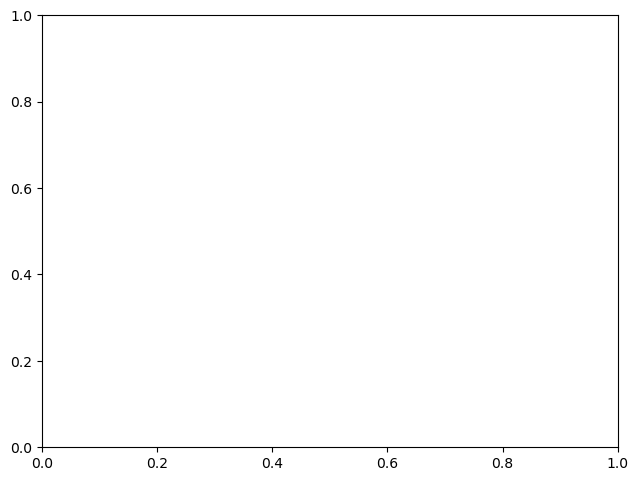

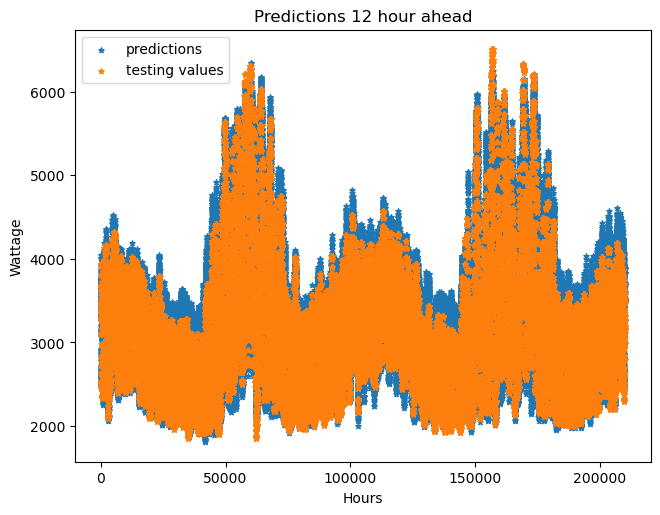

In [21]:
import matplotlib.pyplot as plt 

fig = plt.figure() 

axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
predictionsAdjusted = []
prediction = predictions[0]

for i in prediction:
    for j in i: 
        predictionsAdjusted.append(j)

fig = plt.figure() 
Hours = [i for i in range(len(data[4]) *12)]

axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.scatter(Hours, predictionsAdjusted, label = "predictions", s = 15,  marker = "*")
testingValuesAdjusted = [] 


for i in predictions[1]: # getting the actual testing values. 
    for j in i: 
        testingValuesAdjusted.append(j)
axes.scatter(Hours, testingValuesAdjusted, label = "testing values",s = 15,  marker = "*")
axes.set_xlabel("Hours")
axes.set_ylabel("Wattage")
plt.title("Predictions 12 hour ahead")
axes.legend() 

# Calculate the MAE for Work Day and Weekend Days! 

In [ ]:
display(LSTMData)

,Annual Usage (kWh),Year,Month,Day,Hour,WeekDay or Weekend,HVN_lon,HVN_lat,HVN_tmpf,HVN_drct,...,DXR_drct,DXR_sknt,DXR_vsby,MMK_lon,MMK_lat,MMK_tmpf,MMK_drct,MMK_sknt,MMK_vsby,HotTemperatures
0,13244.454545,2011,1,1,0,0,-72.8868,41.2638,33.980000,190.000000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
1,13244.454545,2011,1,1,1,0,-72.8868,41.2638,37.940000,63.333333,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
2,13244.454545,2011,1,1,2,0,-72.8868,41.2638,37.040000,200.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,5.0,5.0,0
3,13244.454545,2011,1,1,3,0,-72.8868,41.2638,33.980000,130.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,4.0,6.0,0
4,13244.454545,2011,1,1,4,0,-72.8868,41.2638,30.920000,130.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,28.94,100.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96422,14064.500000,2021,12,31,19,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96423,14064.500000,2021,12,31,20,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96424,14064.500000,2021,12,31,21,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96425,14064.500000,2021,12,31,22,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0


# Weekday Weekend Results

In [ ]:
MAE_results = [0 for i in range(0,24,1)]
MAE_results2 = [0 for i in range(0,24,1)]
import datetime
def weekDayMAE(LSTMData, MAE_results, predictionsAdjusted, testingAdjusted):
    for i in range(0, 24, 1):
        HourlyPredictedVals = []
        HourlyActualVals = []  
        for index in range(0,len(predictionsAdjusted)): 
             datetimeObj = datetime.datetime(LSTMData.iloc[index + 18 + 61363, 1], LSTMData.iloc[index + 18 + 61363, 2], LSTMData.iloc[index + 18 + 61363, 3])
             if LSTMData.iloc[index + 18, 4] == i and datetimeObj.isoweekday() <=5: # if it is a weekday
                 HourlyPredictedVals.append(predictionsAdjusted[index])
                 HourlyActualVals.append(testingAdjusted[index])
        error = mean_absolute_error(HourlyPredictedVals, HourlyActualVals)
        MAE_results[i] = error; 

In [ ]:
def weekEndMAE(LSTMData, MAE_results, predictionsAdjusted, testingAdjusted):
    for i in range(0, 24, 1):
        HourlyPredictedVals = []
        HourlyActualVals = []  
        for index in range(0,len(predictionsAdjusted)): 
             datetimeObj = datetime.datetime(LSTMData.iloc[index + 18 + 61363, 1], LSTMData.iloc[index + 18 + 61363, 2], LSTMData.iloc[index + 18 + 61363, 3])
             if LSTMData.iloc[index + 18, 4] == i and datetimeObj.isoweekday() >5: # if it is a weekday
                 HourlyPredictedVals.append(predictionsAdjusted[index])
                 HourlyActualVals.append(testingAdjusted[index])
        error = mean_absolute_error(HourlyPredictedVals, HourlyActualVals)
        MAE_results[i] = error; 

In [ ]:
weekDayMAE(LSTMData, MAE_results, predictions, data[5])
weekEndMAE(LSTMData, MAE_results2, predictions, data[5])

Text(0.5, 1.0, 'LSTM6_Weekday')

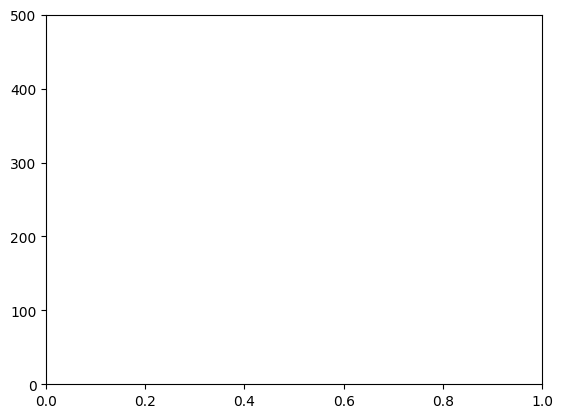

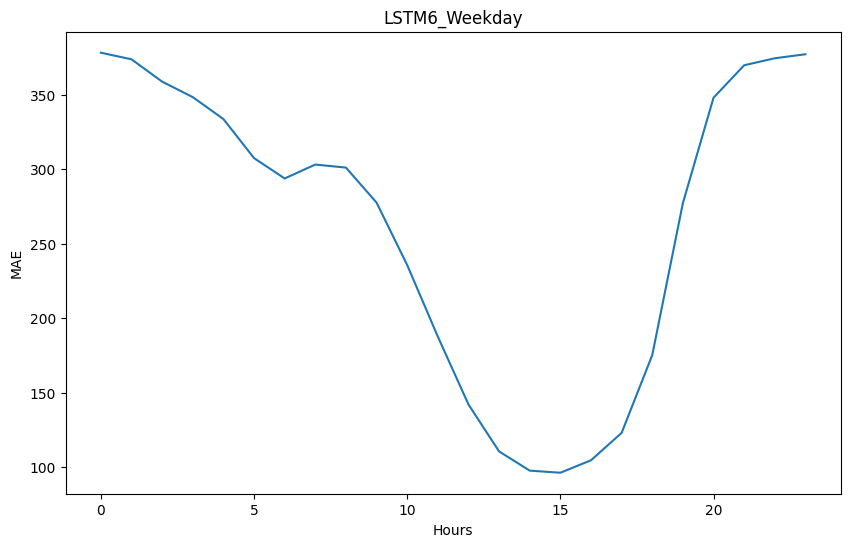

In [ ]:
Hours = [i for i in range(24)]
plt.ylim(0, 500)
plt.figure(figsize=(10,6))
plt.plot(Hours, MAE_results)
plt.xlabel("Hours")
plt.ylabel("MAE")
plt.title("LSTM6_Weekday")

Text(0.5, 1.0, 'LSTM6_Weekend')

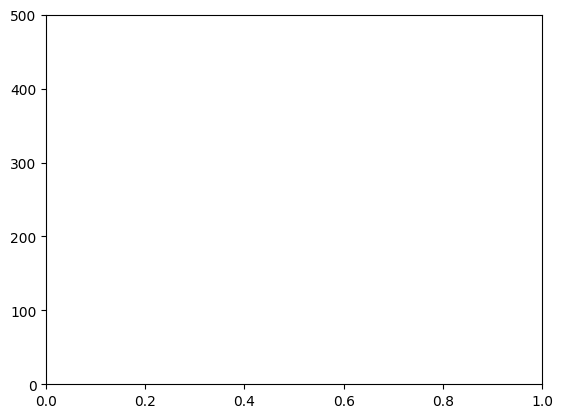

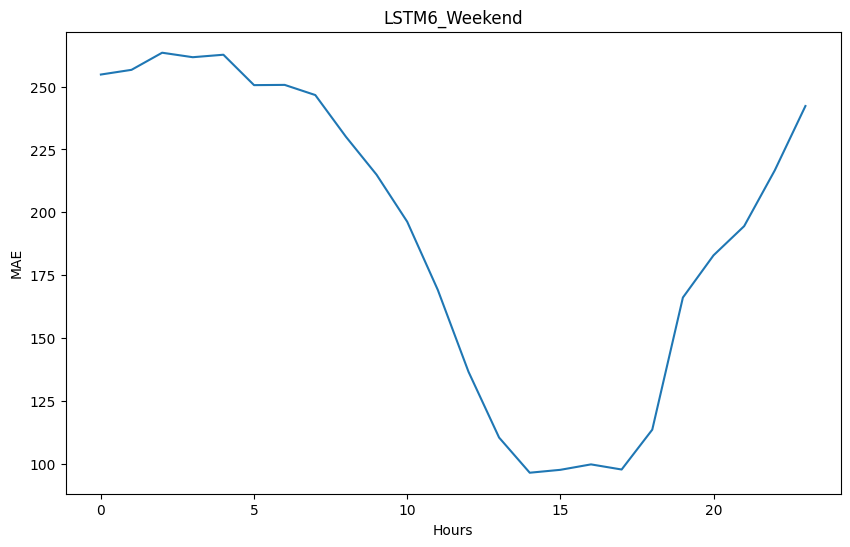

In [ ]:
plt.ylim(0, 500)
plt.figure(figsize=(10,6))
plt.plot(Hours, MAE_results2)
plt.xlabel("Hours")
plt.ylabel("MAE")
plt.title("LSTM6_Weekend")